<a href="https://colab.research.google.com/github/joyceee916/ATMS-597-SP-2020/blob/master/Project4_Joyce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [53]:
cd /content/drive/My Drive/ATMS 597/Project4

/content/drive/My Drive/ATMS 597/Project4


Tasks
1. Use multiple linear regression to predict weather using past Global Forecast System (GFS) forecast data. 

2. Use random forest regression to predict weather using past GFS forecast data. 

Predict these variables for the period 6 UTC to 6 UTC the following day: 
* Maximum Temperature (C)
* Minimum Temperature (C)
* Maximum Wind Speed (m/s)
* Total precipitation accumulation (mm)



Day 0 at 12 UTC: you will have a model run (that's given to you)
* can incorporate observations up to but not including 00UTC 
* at the point of 00UTC will predict from 06UTC to 06UTC the next day 

Have 2 observational files (can be used in training, can also be used for verification)
* KCMI_hourly.csv
* KCMI_daily_obs.csv
* ^^ have to sum hourly observations to get total precipitation, has daily values even though the column heading says "hourly"

use pr1h or pr6h to correct for seasonal biases? (seems optional?) 

from the GFS: 
* daily.tar.gz, prof.tar.gz, sfc.tar.gz (UNIX zip files)
* for each run they contain a csv file that has the GFS forecast data 
* sfc.tar.gz - has a lot of data if you want to play around with it (sounds optional)
* prof.tar.gz - some upper air values (includes ~5 pressure levels) (can include if you want to) (sounds optional)
* each run has a timestamp that starts at 12UTC

main challenge: to get data lined up in Pandas 

start simple: start with a few variables and do a multiple linear regression, make sure things are working right 

could generate a persistence variable, try to predict tomorrow's data 

then could slowly add in more variables as you get more confidence 

could select different columns and see if your biases get better or worse as you swap out different columns - could write a function for this? 

2019 as a validation set 

calculate one metric: the RMS error (performance metric)

this week, focus on getting data read in and organized 



NOW: CAN SUBSTITUTE BICYCLE RIDERS IN WITH TEMPERATURE DATA (MODULE 4 NOTEBOOK 1): PREDICT TEMPERATURE TOMORROW 

In [0]:
KCMI_daily_df = pd.read_csv("KCMI_daily.csv", skiprows=8, parse_dates=True, index_col = 'Date')

In [0]:
KCMI_daily_df = KCMI_daily_df.iloc[0:3652, 0:4]

In [56]:
KCMI_daily_df.head()

,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in)
Date,,,,
2010-01-01,12,2,15,M
2010-01-02,6,-5,15,0.00
2010-01-03,10,-6,11,0.00
2010-01-04,11,-2,20,0.00
2010-01-05,10,-1,16,M


In [57]:
KCMI_daily_df.rename(columns={'Max Hourly Temp (F)': 'Max_Temp', 'Min Hourly Temp (F)': 'Min_Temp', 'Max Wind Speed (mph)': 'Max_Wind', 'Total Precip (in)': 'Total_Precip'}, inplace = True)
KCMI_daily_df

,Max_Temp,Min_Temp,Max_Wind,Total_Precip
Date,,,,
2010-01-01,12,2,15,M
2010-01-02,6,-5,15,0.00
2010-01-03,10,-6,11,0.00
2010-01-04,11,-2,20,0.00
2010-01-05,10,-1,16,M
...,...,...,...,...
2019-12-27,43,32,15,0.00
2019-12-28,56,32,23,0.23
2019-12-29,59,41,23,0.22


In [0]:
Practice_KCMI_daily = KCMI_daily_df[:]

In [59]:
Practice_KCMI_daily = Practice_KCMI_daily[(Practice_KCMI_daily!='M')]
Practice_KCMI_daily

,Max_Temp,Min_Temp,Max_Wind,Total_Precip
Date,,,,
2010-01-01,12,2,15,NaN
2010-01-02,6,-5,15,0.00
2010-01-03,10,-6,11,0.00
2010-01-04,11,-2,20,0.00
2010-01-05,10,-1,16,NaN
...,...,...,...,...
2019-12-27,43,32,15,0.00
2019-12-28,56,32,23,0.23
2019-12-29,59,41,23,0.22


In [0]:
# TODO change back to KCMI_daily 
# Get Rid of NaN values 
col_mask=Practice_KCMI_daily.isnull().any(axis=0) 
row_mask=Practice_KCMI_daily.isnull().any(axis=1)
Practice_KCMI_daily.loc[row_mask,col_mask]

Practice_KCMI_daily.dropna(inplace=True)

In [0]:
# create an array of the dates where Total_Precip=M 
M_dates = KCMI_daily_df.index[(KCMI_daily_df.Total_Precip == 'M')]

Bring In KCMI Hourly Data

In [0]:
KCMI_hourly_df = pd.read_csv("KCMI_hourly.csv", parse_dates=True, index_col = 'Timestamp')

In [63]:
KCMI_hourly_df.head()

,year,month,day,hour,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,pr6h,doy,woy
Timestamp,,,,,,,,,,,,,,
2005-12-31 19:00:00,2006,1,1,1,0.6,-1.7,1012.6,220.0,2.1,2.0,0.0,NaN,365,52
2005-12-31 20:00:00,2006,1,1,2,0.0,-1.7,1012.9,160.0,2.1,0.0,0.0,NaN,365,52
2005-12-31 21:00:00,2006,1,1,3,-0.6,-2.2,1013.4,170.0,1.5,0.0,0.0,NaN,365,52
2005-12-31 22:00:00,2006,1,1,4,-1.1,-2.2,1012.9,160.0,3.1,0.0,0.0,NaN,365,52
2005-12-31 23:00:00,2006,1,1,5,-1.1,-2.2,1013.1,160.0,3.1,0.0,0.0,NaN,365,52


clean up and rename columns? 

In [0]:
# Use M_dates to select out dates from KCMI_hourly
# Sum hourly values from KCMI_hourly 
# Bring those values back into KCMI_daily 

Linear Regression 

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [65]:
# TODO change back to KCMI_daily 
x = Practice_KCMI_daily.drop(['Total_Precip'], axis=1)
y = Practice_KCMI_daily['Total_Precip']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1939, 3) (216, 3) (1939,) (216,)


In [72]:
x_train[0:5]

array([['69'],
       ['84'],
       ['23'],
       ['83'],
       ['33']], dtype=object)

In [0]:
model = LinearRegression(fit_intercept=False)

x_train= np.array(x_train['Max_Temp']).reshape(-1, 1)
y_train= np.array(y_train).reshape(-1, 1)
x_test = np.array(x_test['Max_Temp']).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

Coefficients: 
 [[0.00041345]]
Mean squared error: 0.02
Coefficient of determination: 0.00


TypeError: ignored

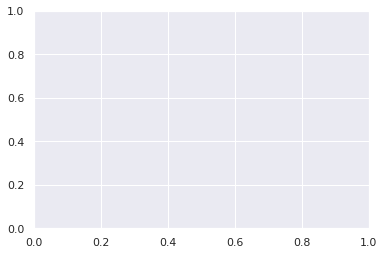

In [74]:
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

print('Coefficients: \n', lin_model.coef_)
print('Mean squared error: %.2f' % mean_squared_error(y_test, lin_model.predict(x_test)))
print('Coefficient of determination: %.2f' % r2_score(y_test, lin_model.predict(x_test)))

plt.scatter(x_test, y_test, color='black')
plt.plot(x_test, lin_model.predict(x_test), color='blue', linewidth=3)

plt.xticks()
plt.yticks()
plt.title('Linear Regression')

Machine Learning

Adapted from:
https://nbviewer.jupyter.org/github/srnghn/ml_example_notebooks/blob/master/Predicting%20Yacht%20Resistance%20with%20Decision%20Trees%20%26%20Random%20Forests.ipynb?source=post_page---------------------------

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# TODO change back to KCMI_daily 
x = Practice_KCMI_daily.drop(['Total_Precip'], axis=1)
y = Practice_KCMI_daily['Total_Precip']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [0]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 

tree_model = DecisionTreeRegressor()
rf_model = RandomForestRegressor()

tree_model.fit(x_train, y_train) 
rf_model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [0]:
# TODO look up difference between mean squared error and mean absolute error 
tree_mse = mean_squared_error(y_train, tree_model.predict(x_train))
tree_mae = mean_absolute_error(y_train, tree_model.predict(x_train))
rf_mse = mean_squared_error(y_train, rf_model.predict(x_train))
rf_mae = mean_absolute_error(y_train, rf_model.predict(x_train))

In [0]:
print("Decision Tree training mse = ",tree_mse," & mae = ",tree_mae," & rmse = ", sqrt(tree_mse))
print("Random Forest training mse = ",rf_mse," & mae = ",rf_mae," & rmse = ", sqrt(rf_mse))

Decision Tree training mse =  0.000370371325425477  & mae =  0.002140278494069108  & rmse =  0.01924503378603106
Random Forest training mse =  0.0027563299475627215  & mae =  0.02149643176404135  & rmse =  0.05250076139983802


In [0]:
tree_test_mse = mean_squared_error(y_test, tree_model.predict(x_test))
tree_test_mae = mean_absolute_error(y_test, tree_model.predict(x_test))
rf_test_mse = mean_squared_error(y_test, rf_model.predict(x_test))
rf_test_mae = mean_absolute_error(y_test, rf_model.predict(x_test))

In [0]:
print("Decision Tree test mse = ",tree_test_mse," & mae = ",tree_test_mae," & rmse = ", sqrt(tree_test_mse))
print("Random Forest test mse = ",rf_test_mse," & mae = ",rf_test_mae," & rmse = ", sqrt(rf_test_mse))

Decision Tree test mse =  0.04007824074074074  & mae =  0.06689814814814815  & rmse =  0.20019550629507332
Random Forest test mse =  0.024299461099280377  & mae =  0.06208412477954146  & rmse =  0.15588284414675135


Tar Files

In [0]:
Daily_Tar = open("daily.tar.gz")